In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from jax import jit, grad, vmap
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from models import WeightSpaceGaussianProcess, CLDS
import utils


/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Gaussian Process Linear Regression

Consider the model 
$$
    y_t = A(c_t) x_t
$$
for data $y_t$, regressors $x_t \in \mathcal{X}$ and conditions $c_t$. We place a GP prior on the linear weights $A(c_t)$ through a weight space decomposition
$$
    [A(c_t)]_{ij} = \sum_k \phi_k (c_t) w^{(ij)}_k, \quad w_k^(ij) \sim \mathcal{N}(0,1)
$$
with basis functions $\phi_k$ and weights $\{w^{(ij)}\}$. We consider the problem of MAP inference of the weights $w$. MAP estimation will amount to the same updates as a standard penalised least squares problem, but with the regressors expressed in some product space of the original regressor space $\mathcal{X}$ and the basis functions $\phi$.

In the first section, we consider the MAP estimation for vector $x$, and in the second for matrix $X$. The latter is useful for EM procedures in an LDS.

In [2]:
# Define model
_sigma, _kappa, _period = 0.2, 0.2, 2*jnp.pi
torus_basis_funcs = utils.T1_basis(3, _sigma, _kappa, _period)

def weight_space_coefficients(m):
    return _sigma * jnp.sqrt(jnp.exp(- 2* jnp.pi**2 * _kappa**2 * m**2))

latent_dim = 2
obs_dim = 3
A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=obs_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=obs_dim, D2=1)

[xla_bridge.py][2024-11-21 12:48:33,151] INFO - Unable to initialize backend 'cuda': 


[xla_bridge.py][2024-11-21 12:48:33,153] INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[xla_bridge.py][2024-11-21 12:48:33,155] INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [3]:
def diag_penalty(N):
    coeffs = []
    for n in jnp.arange(-N, N):
        coeff = weight_space_coefficients(n)
        coeffs.append(coeff)
        coeffs.append(coeff) # twice
    return jnp.array(coeffs)

diag_penalty(3)

Array([0.00572739, 0.00572739, 0.0412306 , 0.0412306 , 0.13476509,
       0.13476509, 0.2       , 0.2       , 0.13476509, 0.13476509,
       0.0412306 , 0.0412306 ], dtype=float32)

## Vector case

In [4]:
def func(key, As, bs, xs):
    T, D2, D1 = As.shape
    def f(A, b, x, _key):
        noise = noise_scale * jxr.normal(_key, (D2,))
        return A @ x + b + noise
    subkeys = jxr.split(key, num=(As.shape[0],))
    ys = vmap(f)(As, bs, xs, subkeys)
    return ys

# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

m0 = jnp.zeros(latent_dim)
S0 = jnp.eye(latent_dim)
noise_scale = 0.05
true_key = jxr.PRNGKey(44)
key1, key2 = jxr.split(true_key)
As = A_prior.sample(key1, theta)
bs = b_prior.sample(key2, theta).squeeze()

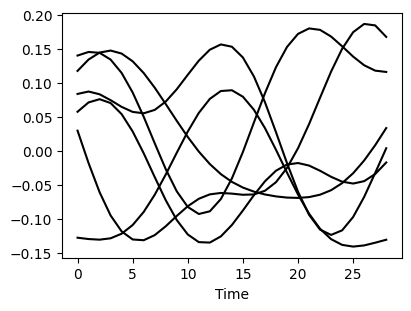

In [5]:
fig, ax = plt.subplots(figsize=[4,3], constrained_layout=True)
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        ax.plot(As[:29, i, j], c='k')
ax.set_xlabel('Time')
plt.savefig('figures/As_samples.eps', format='eps')

In [6]:
# Generate Xs
key = jxr.PRNGKey(0)
B = 100
X = jxr.normal(key, (B, num_timesteps, latent_dim))
Y = jax.vmap(lambda _key, _xs: func(_key, As, bs, _xs), in_axes=(0,0))(jxr.split(key, num=B), X)

Text(0.5, 1.0, 'A recovery')

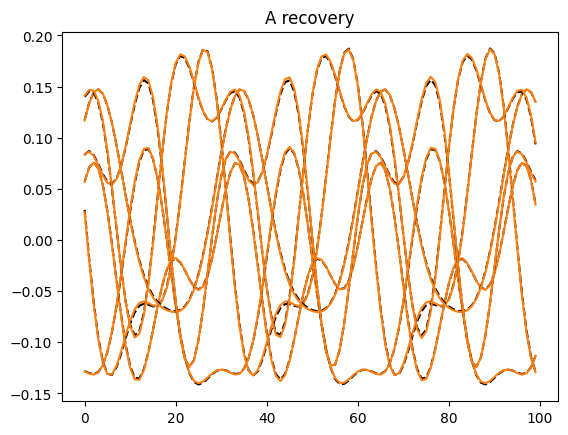

In [7]:
# Do the weight-space lin reg for A

conditions = theta#[:-1]
Ex = X.mean(0)
Exp = Ex[:-1]
Exn = Ex[1:]

len_basis = len(A_prior.basis_funcs)    
D1 = A_prior.D1
D2 = A_prior.D2

PhiAp = A_prior.evaluate_basis(conditions) # shape T x K
def e_step(xs, ys):
    _Y = ys - bs#[:,None] # shape T x D1

    Z = jnp.einsum('tk,ti->tik', PhiAp, xs)
    ZTZ = jnp.einsum('tik,tjl->ikjl', Z, Z).reshape(len_basis * D2, len_basis * D2)
    ZTY = jnp.einsum('tik,tj->ikj', Z, _Y).reshape(len_basis * D2, D1)
    stats = (ZTZ, ZTY)
    return stats

def m_step(stats):
    ZTZ, ZTY = stats
    w_MAP = jax.scipy.linalg.solve(ZTZ + noise_scale**2 * jnp.eye(len_basis * D2), ZTY, assume_a='pos')
    w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
    return w_MAP

# Fitting
batch_stats = vmap(e_step)(X, Y)
stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)
w_MAP = m_step(stats)

A_recovered = A_prior(w_MAP, conditions)

plt.figure()
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        plt.plot(As[:,i,j], 'k--')
        plt.plot(A_recovered[:,i,j], c='tab:orange')

plt.title('A recovery')
# plt.plot([jnp.linalg.det(F).itzem() for F in As])
# plt.plot([jnp.linalg.det(F).item() for F in A_recovered])

Text(0.5, 1.0, 'A recovery')

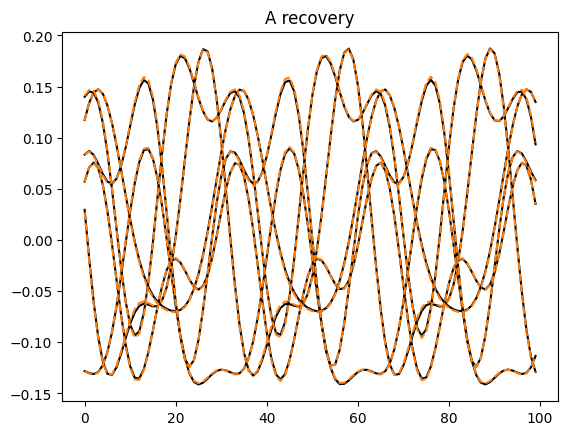

In [10]:
conditions = jnp.tile(theta, (B, 1))
targets = Y - bs[None, ...]
regressors = X

w_MAP = A_prior.fit(conditions, targets, regressors, noise_cov=noise_scale**2)
A_recovered = A_prior(w_MAP, theta)

plt.figure()
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        plt.plot(As[:,i,j], 'k')
        plt.plot(A_recovered[:,i,j], ls='--', c='tab:orange')

plt.title('A recovery')

Text(0.5, 1.0, 'b recovery')

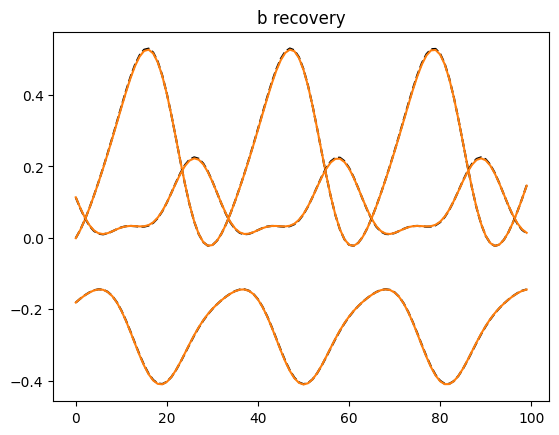

In [10]:
# Do the weight-space lin reg for A

conditions = theta#[:-1]
Ex = X.mean(0)
Exp = Ex[:-1]
Exn = Ex[1:]

len_basis = len(b_prior.basis_funcs)    
D1 = b_prior.D1
D2 = b_prior.D2

Phib = b_prior.evaluate_basis(conditions) # shape T x K
def b_e_step(xs, ys):
    _Y = ys - jax.vmap(lambda A, x: A @ x)(As, xs) # shape T x D1
    Z = Phib.reshape(len(_Y), D2, len_basis)
    ZTZ = jnp.einsum('tki,tlj->kilj', Z, Z).reshape(len_basis * D2, len_basis * D2)
    ZTY = jnp.einsum('tki,tj->kij', Z, _Y).reshape(len_basis * D2, D1)
    stats = (ZTZ, ZTY)
    return stats

def b_m_step(stats):
    ZTZ, ZTY = stats
    w_MAP = jax.scipy.linalg.solve(ZTZ + noise_scale**2 * jnp.eye(len_basis * D2), ZTY, assume_a='pos')
    w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
    return w_MAP

# Fitting
batch_stats = vmap(b_e_step)(X, Y)
stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)
w_MAP = b_m_step(stats)

b_recovered = b_prior(w_MAP, conditions)

plt.figure()
for i in range(b_prior.D1):
    for j in range(b_prior.D2):
        plt.plot(bs[:,i], 'k--')
        plt.plot(b_recovered[:,i], c='tab:orange')
plt.title('b recovery')

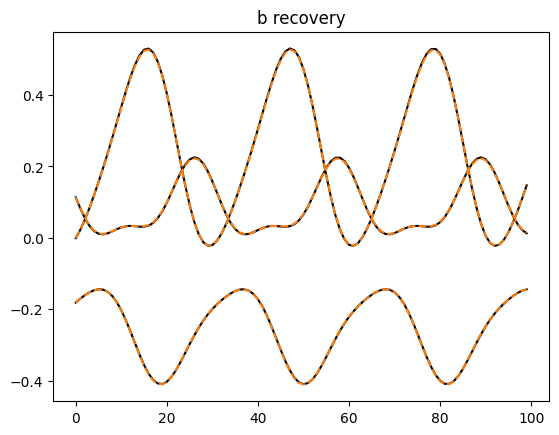

In [22]:
conditions = jnp.tile(theta, (B, 1))
targets = vmap(lambda x, y: y - jax.vmap(lambda A, x: A @ x)(As, x))(X, Y)
regressors = None

wb_MAP = b_prior.fit(conditions, targets, regressors, noise_cov=noise_scale**2)
b_recovered = b_prior(wb_MAP, theta).squeeze()

plt.figure()
plt.plot(bs, 'k')
plt.plot(b_recovered, ls='--', c='tab:orange')
plt.title('b recovery');

## Matrix case

In [11]:
def func(key, As, Xs):
    T, D1, D2 = As.shape
    def f(A, X, _key):
        noise = noise_scale * jxr.normal(_key, (D1, D2,))
        return A @ X + noise
    subkeys = jxr.split(key, num=(As.shape[0],))
    Ys = vmap(f)(As, Xs, subkeys)
    return Ys

# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

true_key = jxr.PRNGKey(44)
A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=obs_dim, D2=latent_dim)
As = A_prior.sample(true_key, theta)

# Generate data
def generate_batch(key):
    key1, key2 = jxr.split(key)
    Xs = jxr.normal(key1, (num_timesteps, latent_dim, latent_dim))
    Ys = func(key2, As, Xs)
    return Xs, Ys

B = 500
X, Y = jax.vmap(generate_batch)(jxr.split(jxr.PRNGKey(0), num=B))
print(X.shape)

(500, 100, 2, 2)


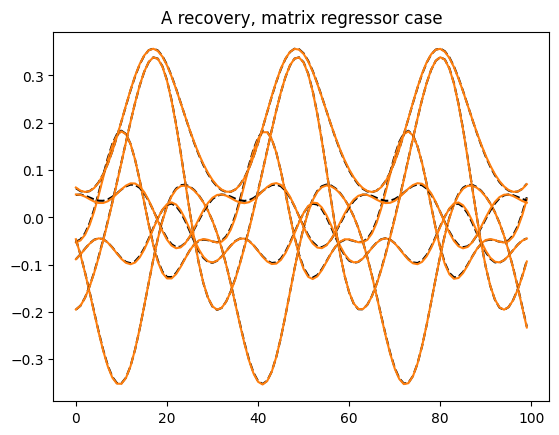

In [12]:
# Do the weight-space lin reg for A

conditions = theta
PhiA = A_prior.evaluate_basis(conditions) # shape T x K

len_basis = len(A_prior.basis_funcs)
D1 = A_prior.D1
D2 = A_prior.D2

def e_step(Xs, Ys):
    # # With A X^T Y + A^T X^T X A form, given X and Y
    # Z = jnp.einsum('tk,tij->tijk', PhiA, Xs) # Each X is a matrix of shape D1 x D2
    # ZTZ = jnp.einsum('timk,tjml->ikjl', Z, Z).reshape(len_basis * D2, len_basis * D2)
    # ZTY = jnp.einsum('timk,tjm->ikj', Z, Ys).reshape(len_basis * D2, D1)

    # With A U + A^T V A form, given U and V
    U = jnp.einsum('tmi,tjm->tij', Xs, Ys) # will be given
    V = jnp.einsum('tim,tmj->tij', Xs, Xs) # will be given
    ZTY = jnp.einsum('tk,tij->ikj', PhiA, U).reshape(len_basis * D2, D1)
    AV = jnp.einsum('tk,tij->tijk', PhiA, V)
    ZTZ = jnp.einsum('tijk,tl->ikjl', AV, PhiA).reshape(len_basis * D2, len_basis * D2)
    stats = (ZTZ, ZTY)
    return stats

def m_step(stats):
    ZTZ, ZTY = stats
    # w_MAP = jax.scipy.linalg.solve(ZTZ + noise_scale**2 * jnp.eye(len_basis * D2), ZTY)
    w_MAP = utils.jax_solve_sylvester_BS(ZTZ, noise_scale**2 * jnp.eye(D1), ZTY, assume_a='pos')
    w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
    return w_MAP

# Fitting
batch_stats = vmap(e_step)(X, Y)
stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)
w_MAP = m_step(stats)

A_recovered = A_prior(w_MAP, conditions)

plt.figure()
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        plt.plot(As[:,i,j], 'k--')
        plt.plot(A_recovered[:,i,j], c='tab:orange')

plt.title('A recovery, matrix regressor case');

In [13]:
# Do the weight-space lin reg for A

conditions = theta
PhiA = A_prior.evaluate_basis(conditions) # shape T x K

len_basis = len(A_prior.basis_funcs)
D1 = A_prior.D1
D2 = A_prior.D2

# def e_step(Xs, Ys):
#     # # With A X^T Y + A^T X^T X A form, given X and Y
#     # Z = jnp.einsum('tk,tij->tijk', PhiA, Xs) # Each X is a matrix of shape D1 x D2
#     # ZTZ = jnp.einsum('timk,tjml->ikjl', Z, Z).reshape(len_basis * D2, len_basis * D2)
#     # ZTY = jnp.einsum('timk,tjm->ikj', Z, Ys).reshape(len_basis * D2, D1)

#     # With A U + A^T V A form, given U and V
#     U = jnp.einsum('tmi,tjm->tij', Xs, Ys) # will be given
#     V = jnp.einsum('tim,tmj->tij', Xs, Xs) # will be given
#     ZTY = jnp.einsum('tk,tij->ikj', PhiA, U).reshape(len_basis * D2, D1)
#     AV = jnp.einsum('tk,tij->tijk', PhiA, V)
#     ZTZ = jnp.einsum('tijk,tl->ikjl', AV, PhiA).reshape(len_basis * D2, len_basis * D2)
#     stats = (ZTZ, ZTY)
#     return stats

# def m_step(stats):
#     ZTZ, ZTY = stats
#     # w_MAP = jax.scipy.linalg.solve(ZTZ + noise_scale**2 * jnp.eye(len_basis * D2), ZTY)
#     w_MAP = utils.jax_solve_sylvester_BS(ZTZ, noise_scale**2 * jnp.eye(D1), ZTY, assume_a='pos')
#     w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
#     return w_MAP

# Fitting
# batch_stats = vmap(e_step)(X, Y)
# stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)

C = jnp.tile(conditions, (B, 1)).reshape(B, num_timesteps, 1)
print(C.shape, X.shape, Y.shape)
w_MAP = A_prior.fit(C, Y, X)

A_recovered = A_prior(w_MAP, conditions)

plt.figure()
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        plt.plot(As[:,i,j], 'k--')
        plt.plot(A_recovered[:,i,j], c='tab:orange')

plt.title('A recovery, matrix regressor case');

(500, 100, 1) (500, 100, 2, 2) (500, 100, 3, 2)


ValueError: Einstein sum subscript 'ti' does not contain the correct number of indices for operand 0.